In [31]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as fsm
import statsmodels.api as sm
import scipy as sp

from scipy.cluster.hierarchy import dendrogram
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import cluster
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.utils import read_sample
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from collections import Counter as ctr

In [32]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

In [33]:
def getVif(dFrame):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(dFrame.values, i) for i in range(dFrame.shape[1])]
    vif["features"] = dFrame.columns
    return vif

In [4]:
ipoRawData = pd.read_excel('IPO_data.xlsx')

In [5]:
ipoData = ipoRawData.rename(columns={
    'Issuer Company': 'IssueComp',
    'Lot Size': 'LotSize',
    'Issue Price(Rs)': 'IssuePrice',
    'Issue Size (Rs Cr)': 'IssueSize',
    'Face Value (INR per share)': 'FaceValue',
    'Latest Revenue (INR in Lakh)': 'LastRevenue',
    'Net Asset Value (NAV) (INR per share)': 'NAV',
    'Issue Type': 'IssueType',
    'Earning Per Share (EPS)(INR)': 'EPS',
    'Price Per Earning (P/E ratio)': 'PERatio',
    'Return on NetWorth (RONW)(in %)': 'RONW',
    'Issue open for (Days)': 'DaysOpen',
    'Subscription Ratio': 'SubRatio',
    'Is Mainboard IPO': 'IsMain',
    'Listing Day Close Price (Rs)': 'ClosePrice'
})

In [ ]:
ipoData.info()

In [ ]:
ipoData.isnull().sum()

In [34]:
ipoData.IssueSize = [x*10000000 for x in ipoData.IssueSize]
ipoData['Shares'] = [x/y for x,y in zip(ipoData.IssueSize, ipoData.IssuePrice)]
ipoData.PERatio = [y/z if np.isnan(x) else x for x, y, z in zip(ipoData.PERatio, ipoData.IssuePrice, ipoData.EPS)]

In [ ]:
ipoData.info()

In [ ]:
print("Issue Type for Mainboard IPO")
ipoData[ipoData.IsMain == 1].IssueType.value_counts()

In [ ]:
print("Issue Type for SME IPO")
ipoData[ipoData.IsMain == 0].IssueType.value_counts()

In [35]:
colsToIgnore = ['IssueComp', 'Exchange', 'Open', 'Close', 'IssueType']
colsNumeric = list(set(ipoData)  - set(colsToIgnore))
# ipoDataImputed = pd.DataFrame(KNN(k = 5).fit_transform(ipoData[colsNumeric]), columns = colsNumeric)
# ipoDataImputed.info()

In [ ]:
# ipoModelData = pd.concat([ipoData[colsToIgnore], ipoDataImputed], axis = 1)

In [36]:
ipoModelData = ipoData.copy()
ipoModelData = ipoModelData.fillna(value = 0, axis = 0)

In [37]:
#Dummy Code Issue Types
ipoDataDummied = pd.get_dummies(ipoModelData, columns = ['IssueType'])

In [38]:
ipoDataDummied = ipoDataDummied.rename(columns = {
    'IssueType_Book Built Issue IPO': 'BBIIPO',
    'IssueType_Fixed Price Issue IPO': 'FPIIPO'
})

In [ ]:
ipoDataDummied.columns

In [64]:
# smeData = ipoDataDummied[ipoDataDummied.IsMain == 0]
# mainData = ipoDataDummied[ipoDataDummied.IsMain == 1]
mainData = ipoDataDummied[ipoDataDummied.Clusters == 1]
smeData = ipoDataDummied[ipoDataDummied.Clusters == 2]
# print("------------SME IPO Information-------------")
# print(smeData.info())

# print("------------MainBoard IPO Information-------------")
# print(mainData.info())

In [ ]:
print('-------------------------SME IPO Description-----------------')
desCols = ['LotSize', 'IssuePrice', 'IssueSize', 'FaceValue', 'SubRatio', 'DaysOpen', 'ClosePrice']
smeData[desCols].describe()

In [ ]:
smeData[smeData.columns.difference(desCols)].describe()

In [ ]:
mainData[desCols].describe()

In [ ]:
print('-------------------------MainBoard IPO Description-----------------')
mainData[mainData.columns.difference(desCols)].describe()

In [ ]:
smeData.head()

In [ ]:
smeData.tail()

In [ ]:
mainData.head()

In [ ]:
mainData.tail()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.LotSize, ax = ax[0]).set_title("SME IPO - Lot Size - Histogram")
sns.boxplot(smeData.LotSize, ax = ax[1]).set_title("SME IPO - Lot Size - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Lot Size - Box Plot')

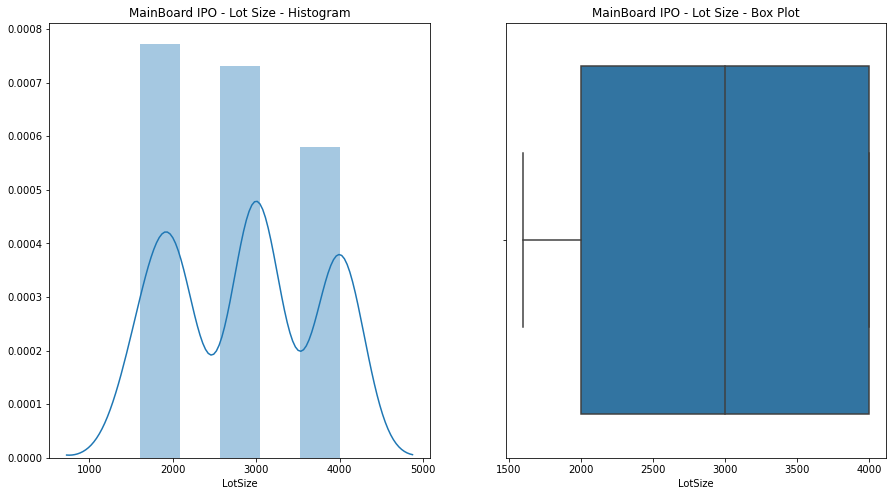

In [65]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.LotSize, ax = ax[0]).set_title("MainBoard IPO - Lot Size - Histogram")
sns.boxplot(mainData.LotSize, ax = ax[1]).set_title("MainBoard IPO - Lot Size - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.RONW, ax = ax[0]).set_title("SME IPO - Returns on Net worth - Histogram")
sns.boxplot(smeData.RONW, ax = ax[1]).set_title("SME IPO - Returns on Net worth - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Returns on Net worth - Box Plot')

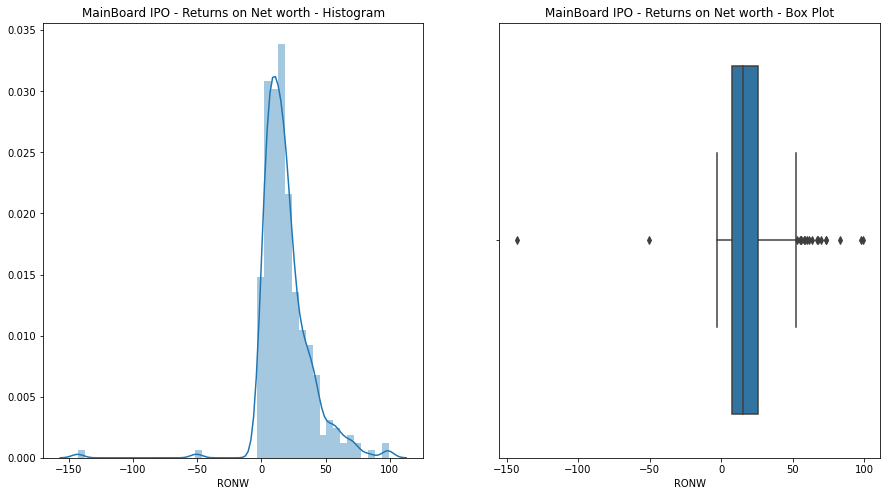

In [66]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.RONW, ax = ax[0]).set_title("MainBoard IPO - Returns on Net worth - Histogram")
sns.boxplot(mainData.RONW, ax = ax[1]).set_title("MainBoard IPO - Returns on Net worth - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.PERatio, ax = ax[0]).set_title("SME IPO - PE Ratio - Histogram")
sns.boxplot(smeData.PERatio, ax = ax[1]).set_title("SME IPO - PE Ratio - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - PE Ratio - Box Plot')

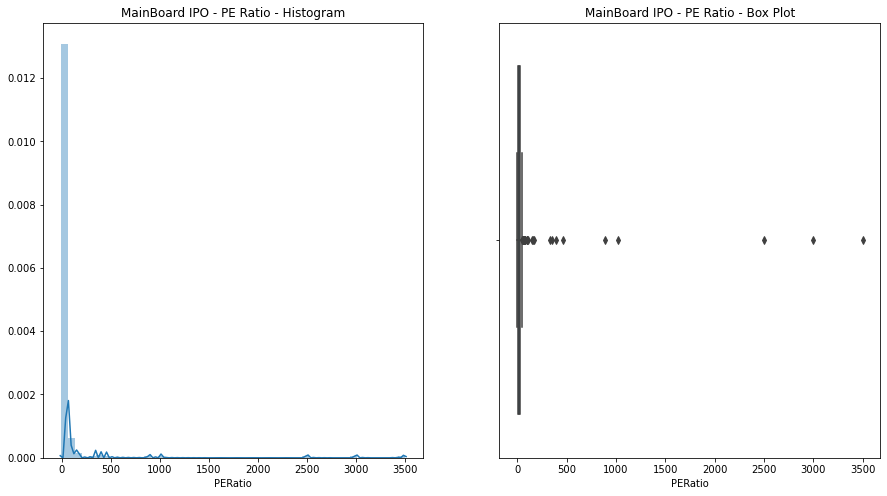

In [67]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.PERatio, ax = ax[0]).set_title("MainBoard IPO - PE Ratio - Histogram")
sns.boxplot(mainData.PERatio, ax = ax[1]).set_title("MainBoard IPO - PE Ratio - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.NAV, ax = ax[0]).set_title("SME IPO - Net Asset Value - Histogram")
sns.boxplot(smeData.NAV, ax = ax[1]).set_title("SME IPO - Net Asset Value - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Net Asset Value - Box Plot')

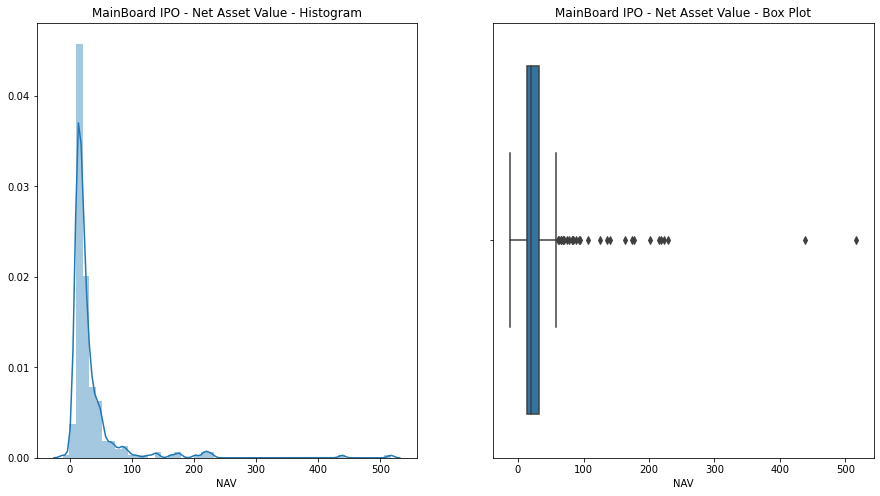

In [68]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.NAV, ax = ax[0]).set_title("MainBoard IPO - Net Asset Value - Histogram")
sns.boxplot(mainData.NAV, ax = ax[1]).set_title("MainBoard IPO - Net Asset Value - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.IssueSize, ax = ax[0]).set_title("SME IPO - Issue Size - Histogram")
sns.boxplot(smeData.IssueSize, ax = ax[1]).set_title("SME IPO - Issue Size - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Issue Size - Box Plot')

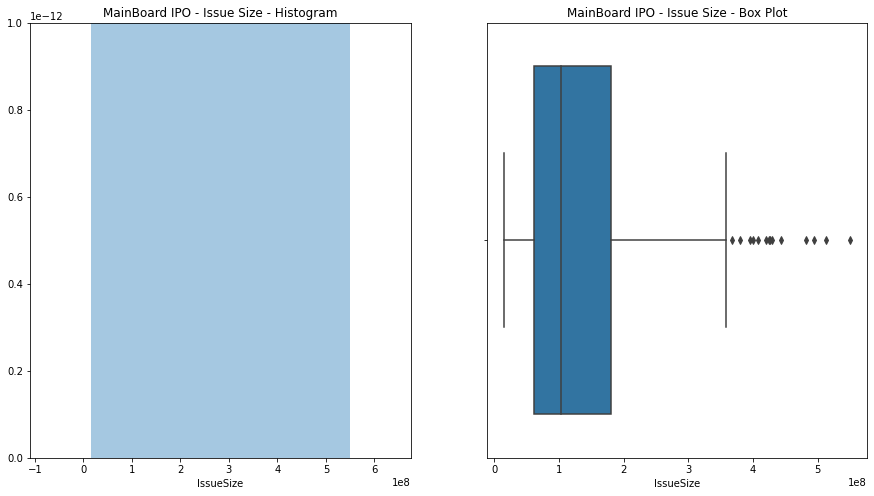

In [69]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.IssueSize, ax = ax[0]).set_title("MainBoard IPO - Issue Size - Histogram")
sns.boxplot(mainData.IssueSize, ax = ax[1]).set_title("MainBoard IPO - Issue Size - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.IssuePrice, ax = ax[0]).set_title("SME IPO - Issue Price - Histogram")
sns.boxplot(smeData.IssuePrice, ax = ax[1]).set_title("SME IPO - Issue Price - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Issue Price - Box Plot')

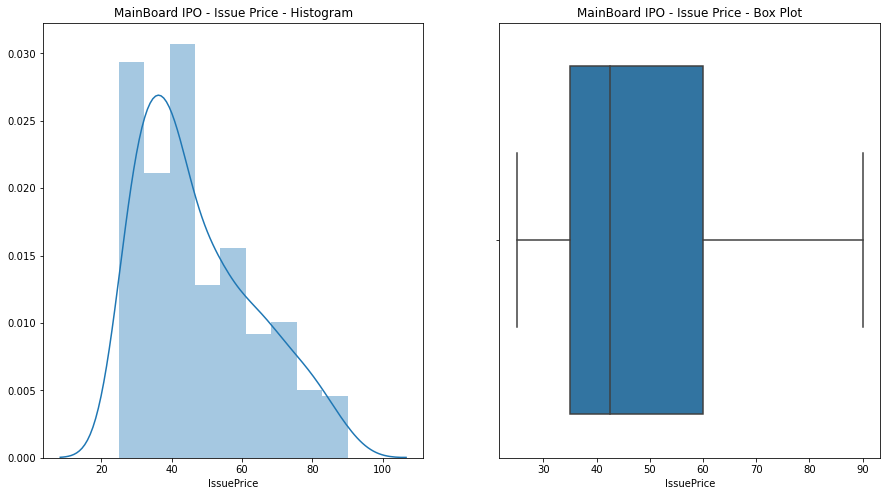

In [70]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.IssuePrice, ax = ax[0]).set_title("MainBoard IPO - Issue Price - Histogram")
sns.boxplot(mainData.IssuePrice, ax = ax[1]).set_title("MainBoard IPO - Issue Price - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.SubRatio, ax = ax[0]).set_title("SME IPO - Subscription Ratio - Histogram")
sns.boxplot(mainData.SubRatio, ax = ax[1]).set_title("SME IPO - Subscription Ratio - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Subscription Ratio - Box Plot')

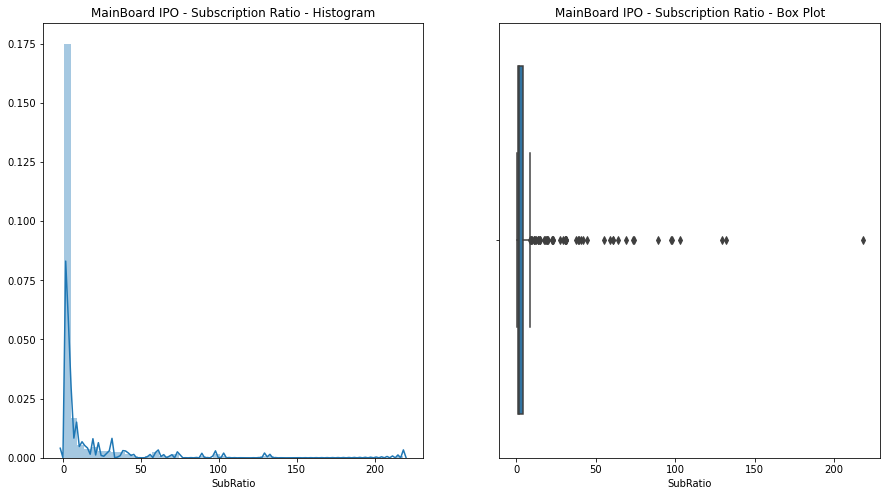

In [71]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.SubRatio, ax = ax[0]).set_title("MainBoard IPO - Subscription Ratio - Histogram")
sns.boxplot(mainData.SubRatio, ax = ax[1]).set_title("MainBoard IPO - Subscription Ratio - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.DaysOpen, ax = ax[0]).set_title("SME IPO - Days Open - Histogram")
sns.boxplot(smeData.DaysOpen, ax = ax[1]).set_title("SME IPO - Days Open - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Days Open - Box Plot')

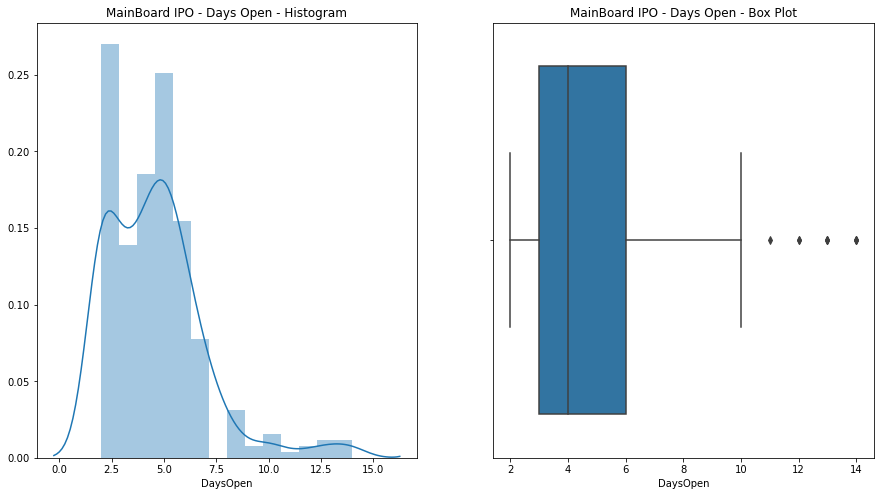

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.DaysOpen, ax = ax[0]).set_title("MainBoard IPO - Days Open - Histogram")
sns.boxplot(mainData.DaysOpen, ax = ax[1]).set_title("MainBoard IPO - Days Open - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.EPS, ax = ax[0]).set_title("SME IPO - Earnings Per Share - Histogram")
sns.boxplot(smeData.EPS, ax = ax[1]).set_title("SME IPO - Earnings Per Share - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Earnings Per Share - Box Plot')

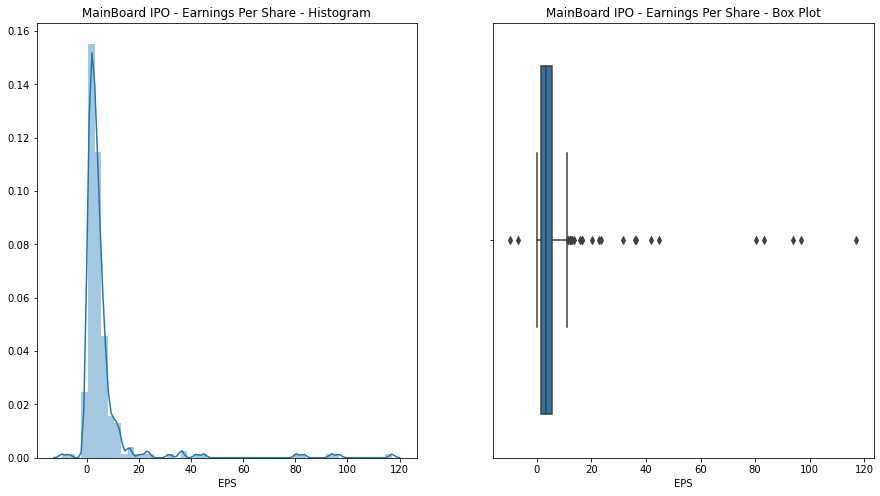

In [39]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.EPS, ax = ax[0]).set_title("MainBoard IPO - Earnings Per Share - Histogram")
sns.boxplot(mainData.EPS, ax = ax[1]).set_title("MainBoard IPO - Earnings Per Share - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.LastRevenue, ax = ax[0]).set_title("SME IPO - Latest Revenue - Histogram")
sns.boxplot(smeData.LastRevenue, ax = ax[1]).set_title("SME IPO - Latest Revenue - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Latest Revenue - Box Plot')

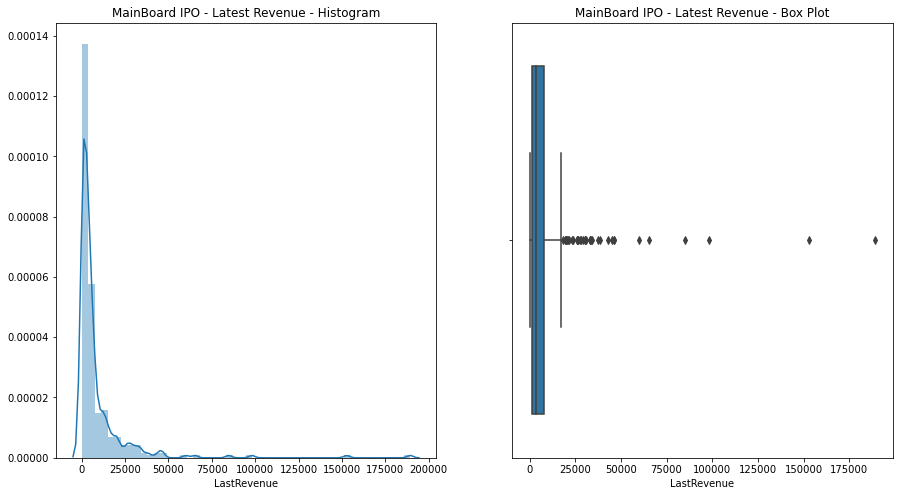

In [40]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.LastRevenue, ax = ax[0]).set_title("MainBoard IPO - Latest Revenue - Histogram")
sns.boxplot(mainData.LastRevenue, ax = ax[1]).set_title("MainBoard IPO - Latest Revenue - Box Plot")

In [ ]:
colsToCorrelate = colsNumeric.copy()
colsToCorrelate.remove('IsMain')
colsToCorrelate.remove('FaceValue')
colsToCorrelate.remove('Shares')
smeCorr = smeData[colsToCorrelate].corr()
mainCorr = mainData[colsToCorrelate].corr()
ipoDataCorr = ipoData[colsToCorrelate].corr()

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ipoDataCorr,cmap='BrBG',annot=True,center = 0).set_title("IPO Data - Correlation Heat Map")

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(smeCorr,cmap='BrBG',annot=True, center = 0)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(mainCorr,cmap='BrBG',annot=True, center = 0)

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LotSize, plData.ClosePrice)
ax.set_xlabel('Lot Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Lot Size Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LotSize, plData.ClosePrice)
ax.set_xlabel('Lot Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Lot Size Vs Close Price')
plt.show()

In [ ]:
plData = smeData[smeData.NAV < 250]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.NAV, plData.ClosePrice)
ax.set_xlabel('Net Asset Value')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Net Asset Value Vs Close Price')
plt.show()

In [ ]:
plData = mainData[mainData.NAV < 200]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.NAV, plData.ClosePrice)
ax.set_xlabel('Net Asset Value')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Net Asset Value Vs Close Price')
plt.show()

In [ ]:
plData = smeData[(smeData.RONW < 50) & (smeData.RONW > -50)]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.RONW, plData.ClosePrice)
ax.set_xlabel('Returns on Net Worth')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Returns on Net Worth Vs Close Price')
plt.show()

In [ ]:
plData = mainData[mainData.RONW < 200]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.RONW, plData.ClosePrice)
ax.set_xlabel('Returns on Net Worth')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Returns on Net Worth Vs Close Price')
plt.show()

In [ ]:
plData = smeData[(smeData.PERatio > -25) & (smeData.PERatio < 100)]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.PERatio, plData.ClosePrice)
ax.set_xlabel('Price to Earnings Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Price to Earnings Ratio Vs Close Price')
plt.show()

In [ ]:
plData = mainData[(mainData.PERatio < 1000) & (mainData.PERatio > -200)]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.PERatio, plData.ClosePrice)
ax.set_xlabel('Price to Earnings Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Price to Earnings Ratio Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.DaysOpen, plData.ClosePrice)
ax.set_xlabel('Days Open')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Days Open Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.DaysOpen, plData.ClosePrice)
ax.set_xlabel('Days Open')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Days Open Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.SubRatio, plData.ClosePrice)
ax.set_xlabel('Subscription Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Subscription Ratio Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.SubRatio, plData.ClosePrice)
ax.set_xlabel('Subscription Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Subscription Ratio Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssuePrice, plData.ClosePrice)
ax.set_xlabel('Issue Price')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Issue Price Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssuePrice, plData.ClosePrice)
ax.set_xlabel('Issue Price')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Issue Price Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.EPS, plData.ClosePrice)
ax.set_xlabel('Earnings Per Share')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Earnings Per Share Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.EPS, plData.ClosePrice)
ax.set_xlabel('Earnings Per Share')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Earnings Per Share Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LastRevenue, plData.ClosePrice)
ax.set_xlabel('Latest Revenue')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Latest Revenue Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LastRevenue, plData.ClosePrice)
ax.set_xlabel('Latest Revenue')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Latest Revenue Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssueSize, plData.ClosePrice)
ax.set_xlabel('Issue Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Issue Size Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssueSize, plData.ClosePrice)
ax.set_xlabel('Issue Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Issue Size Vs Close Price')
plt.show()

In [ ]:
print(colsToCorrelate)
print(mainData.columns)

In [ ]:
vifCols = colsToCorrelate.copy()
vifCols.remove('ClosePrice')
vifCols.append('BBIIPO')
vifCols.remove('EPS')
vifCols.remove('IssueSize')
vifCols.remove('DaysOpen')
vifCols

In [ ]:
#Linear Regression - K Fold - SME IPO
folds = KFold(n_splits = 5)
lmResList = list()
count = 0
for trnIx, tstIx in folds.split(smeData):
    xTrn = smeData.iloc[trnIx,:]
    yTrn = smeData.iloc[trnIx,:]['ClosePrice']
    xTst = smeData.iloc[tstIx,:]
    yTst = smeData.iloc[tstIx,:]['ClosePrice']
    linModel = fsm.ols('ClosePrice ~ LotSize + IssuePrice + RONW + NAV + PERatio + SubRatio + BBIIPO', data = xTrn).fit()
    lm_aov_table = sm.stats.anova_lm(linModel, typ=2)
    predictions = linModel.predict(xTst)
    predictionsTrain = linModel.predict(xTrn)
    lm_MSE = mean_squared_error(yTst, predictions)
    lm_RMSE = math.sqrt(lm_MSE)
    lm_MAE = mean_absolute_error(yTst, predictions)
    lm_MAPE = lm_MAE/len(predictions)
    lm_vif = getVif(xTrn[vifCols])
    lm_MSE_train = mean_squared_error(yTrn, predictionsTrain)
    lm_RMSE_train = math.sqrt(lm_MSE_train)
    lm_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
    lm_MAPE_train = lm_MAE_train/len(predictionsTrain)
    lm_vif = getVif(xTrn[vifCols])
    lmResList.append({
        'trainIndices': trnIx,
        'testIndices': tstIx,
        'model': linModel,
        'AOVTable': lm_aov_table,
        'vif': lm_vif,
        'xTrain': xTrn,
        'yTrain': yTrn,
        'xTest': xTst,
        'yTest': yTst,
        'predictions': predictions,
        'predictionsTrain': predictionsTrain,
        'metrics': {
            'MSE': lm_MSE,
            'RMSE': lm_RMSE,
            'MAE': lm_MAE,
            'MAPE': lm_MAPE,
            'R2': linModel.rsquared,
            'AdjustedR2': linModel.rsquared_adj
        },
        'metricsTrain': {
            'MSE': lm_MSE_train,
            'RMSE': lm_RMSE_train,
            'MAE': lm_MAE_train,
            'MAPE': lm_MAPE_train
        }
    })
    print("------------------------------Linear Regression Response - START ({})------------------------".format(count))
    count+=1
    print(linModel.summary())
    print(lm_aov_table)
    
    print('Mean Squared Error(Train): ', lm_MSE)
    print('Root Mean Squared Error(Train): ', lm_RMSE)
    print('Mean Absolute Error(Train): ', lm_MAE)
    print('Mean Absolute Percentage Error(Train): ', lm_MAPE)
    
    print('Mean Squared Error(Test): ', lm_MSE)
    print('Root Mean Squared Error(Test): ', lm_RMSE)
    print('Mean Absolute Error(Test): ', lm_MAE)
    print('Mean Absolute Percentage Error(Test): ', lm_MAPE)
    
    print('vif', lm_vif)
    print("------------------------------Linear Regression Response - END --------------------------")

lmResListSorted = sorted(lmResList, key = lambda i: i['metrics']['MAPE'])

In [ ]:
lmResListSorted[0]['model'].summary()

In [ ]:
lmResult = lmResListSorted[0]

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(lmResult['predictionsTrain'])+1)]
y1 = lmResult['yTrain']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = lmResult['predictionsTrain']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
lmResult = lmResListSorted[0]

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(lmResult['predictions'])+1)]
y1 = lmResult['yTest']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = lmResult['predictions']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
lmResult['metrics']

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Train Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(lmResult['yTrain'],lmResult['model'].fittedvalues)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Test Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(y1,y2)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.residplot(lmResult['model'].fittedvalues, lmResult['model'].resid, lowess=True, color="g")

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(lmResult['model'].resid)

In [ ]:
sm.qqplot(lmResult['model'].resid, line ='45')

In [ ]:
sp.stats.shapiro(lmResult['model'].resid)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
fig = sm.graphics.influence_plot(lmResult['model'], ax=ax, criterion="cooks")

In [ ]:
# #Logistic Regression - K Fold
# folds = KFold(n_splits = 10)
# logitResList = list()
# count = 0
# for trnIx, tstIx in folds.split(mData_dummied):
#     xTrn = mData_dummied.iloc[trnIx,:]
#     yTrn = mData_dummied.iloc[trnIx,:]['IsProfit']
#     xTst = mData_dummied.iloc[tstIx,:]
#     yTst = mData_dummied.iloc[tstIx,:]['IsProfit']
#     logitModel = fsm.logit('IsProfit ~ LotSize+IssuePrice+EPS+NetAssetValue+IssueSizeCr+NetAssetValue+EMP+RONW', data = xTrn).fit()
#     predictedProbs = logitModel.predict(xTst)
#     predictedClass = [1 if x > 0.5 else 0 for x in predictedProbs]
#     logit_vif = getVif(xTrn[vifCols])
#     confusionMatrix = confusion_matrix(yTst, predictedClass)
#     classificationReport = classification_report(yTst, predictedClass)
#     accuracyScore = accuracy_score(yTst, predictedClass)
#     precisionScore = precision_score(yTst, predictedClass)
#     recallScore = recall_score(yTst, predictedClass)
#     f1Score = f1_score(yTst, predictedClass)
#     fpr, tpr, threshold = roc_curve(yTst, predictedClass)
#     roc_auc = auc(fpr, tpr)
#     logitResList.append({
#         'trainIndices': trnIx,
#         'testIndices': tstIx,
#         'model': logitModel,
#         'vif': logit_vif,
#         'xTrain': xTrn,
#         'yTrain': yTrn,
#         'xTest': xTst,
#         'yTest': yTst,
#         'predictions': predictedClass,
#         'metrics': {
#             'AUC': roc_auc,
#             'ConfusionMatrix': confusionMatrix,
#             'ClassificationReport': classificationReport,
#             'Accuracy':accuracyScore,
#             'Recall':recallScore,
#             'Precision':precisionScore,
#             'F1-Score':f1Score,
#         }
#     })
#     print("------------------------------Logistic Regression Response - START ({})------------------------".format(count))
#     count+=1
#     print(logitModel.summary())
#     print('vif:', logit_vif)
#     print('Confusion Matrix:')
#     print(confusionMatrix)
#     print('Accuracy: ', accuracyScore)
#     print('Classification Report:')
#     print(classificationReport)
#     print('Area Under the Curve: ', roc_auc)
    
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()

#     print("------------------------------Logistic Regression Response - END --------------------------")
    

In [ ]:
mData_dummied.columns

In [ ]:
# #Neural Networks

# folds = KFold(n_splits = 10)
# nnResList = list()
# colsToRemove = ['LDClosePrice', 'IsProfit', 'IT_BBIIPO', 'IT_BBIREIT', 'FaceValue', 'IT_FPIIPO', 'AtBSE', 'AtNSE', 'AtBSESME', 'AtNSEEmerge', 'IsProfit', 'IsMainboardIPO', 'IsSMEIPO', 'RII']
# #LotSize+IssuePrice+EPS+NetAssetValue+IssueSizeCr+EMP+RONW
# colsToInclude = ['LotSize', 'IssuePrice', 'EPS', 'NetAssetValue', 'IssueSizeCr', 'EMP', 'RONW']
# for trnIx, tstIx in folds.split(mData_dummied):
#     xTrn = mData_dummied.iloc[trnIx,:][colsToInclude]
#     yTrn = mData_dummied.iloc[trnIx,:]['LDClosePrice']
#     xTst = mData_dummied.iloc[tstIx,:][colsToInclude]
#     yTst = mData_dummied.iloc[tstIx,:]['LDClosePrice']
#     xLen = len(xTrn.columns)
#     nnModel = Sequential()
#     nnModel.add(Dense(xLen, input_dim=xLen, kernel_initializer='normal', activation='relu'))
#     nnModel.add(Dense(round(xLen/2), kernel_initializer='normal', activation='relu'))
#     nnModel.add(Dense(round(xLen/3), kernel_initializer='normal', activation='relu'))
#     nnModel.add(Dense(1, kernel_initializer='normal'))
#     nnModel.compile(loss='mean_squared_error', optimizer='adam')
#     nnModel.fit(xTrn, yTrn, epochs=200, batch_size=10)
#     predictions = nnModel.predict(xTst)
#     nn_MSE = mean_squared_error(yTst, predictions)
#     nn_RMSE = math.sqrt(nn_MSE)
#     nn_MAE = mean_absolute_error(yTst, predictions)
#     nn_MAPE = nn_MAE/len(predictions)
#     predictionsTrain = nnModel.predict(xTrn)
#     nn_MSE_train = mean_squared_error(yTrn, predictionsTrain)
#     nn_RMSE_train = math.sqrt(nn_MSE_train)
#     nn_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
#     nn_MAPE_train = nn_MAE_train/len(predictionsTrain)
#     nnResList.append({
#         'trainIndices': trnIx,
#         'testIndices': tstIx,
#         'model': nnModel,
#         'xTrain': xTrn,
#         'yTrain': yTrn,
#         'xTest': xTst,
#         'yTest': yTst,
#         'predictions': predictions,
#         'predictionsTrain': predictionsTrain,
#         'metrics': {
#             'MSE': nn_MSE,
#             'RMSE': nn_RMSE,
#             'MAE': nn_MAE,
#             'MAPE': nn_MAPE
#         },
#         'metricsTrain': {
#             'MSE': nn_MSE_train,
#             'RMSE': nn_RMSE_train,
#             'MAE': nn_MAE_train,
#             'MAPE': nn_MAPE_train
#         }        
#     })

In [ ]:
# for nnRes in nnResList:
#     print([nnRes['metrics']['MSE'], nnRes['metrics']['RMSE'], nnRes['metrics']['MAE'], nnRes['metrics']['MAPE']])
    

In [ ]:
# nnResListSorted = sorted(nnResList, key = lambda i: i['metrics']['MAPE'])
# nnLowEr = nnResListSorted[0]

In [ ]:
# fig, ax = plt.subplots(figsize=(15,8))
# # line 1 points
# xAxis = [i for i in range(1,len(nnLowEr['predictionsTrain'])+1)]
# y1 = nnLowEr['yTrain']
# # plotting the line 1 points 
# plt.plot(xAxis, y1, label = "Actual")
# # line 2 points
# y2 = nnLowEr['predictionsTrain']
# # plotting the line 2 points 
# plt.plot(xAxis, y2, label = "Predicted")
# plt.xlabel('Count')
# # Set the y axis label of the current axis.
# plt.ylabel('Listing Day  Close Price')
# # Set a title of the current axes.
# plt.title('Linear Model - Actual vs Predicted (Train Data)')
# # show a legend on the plot
# plt.legend()
# # Display a figure.
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(15,8))
# # line 1 points
# xAxis = [i for i in range(1,len(nnLowEr['predictions'])+1)]
# y1 = nnLowEr['yTest']
# # plotting the line 1 points 
# plt.plot(xAxis, y1, label = "Actual")
# # line 2 points
# y2 = nnLowEr['predictions']
# # plotting the line 2 points 
# plt.plot(xAxis, y2, label = "Predicted")
# plt.xlabel('Count')
# # Set the y axis label of the current axis.
# plt.ylabel('Listing Day  Close Price')
# # Set a title of the current axes.
# plt.title('Neural Networks Model - Actual vs Predicted (Test Data)')
# # show a legend on the plot
# plt.legend()
# # Display a figure.
# plt.show()

In [239]:
clusterData.dtypes

IssuePrice       int64
IssueSize      float64
LastRevenue    float64
LotSize          int64
NAV            float64
PERatio        float64
RONW           float64
Shares         float64
SubRatio       float64
dtype: object

In [238]:
getVif(clusterData)

VIF Factor     features
0    2.090136   IssuePrice
1    1.991820    IssueSize
2    1.353061  LastRevenue
3    1.054562      LotSize
4    1.386060          NAV
5    1.063748      PERatio
6    1.134674         RONW
7    1.539580       Shares
8    1.242097     SubRatio

In [57]:
colsToIgnore = ['Cluster','IssueComp', 'Exchange', 'Open', 'Close', 'BBIIPO', 'FaceValue','ClosePrice','EPS', 'DaysOpen', 'IsMain','FPIIPO']
clusterData = ipoDataDummied[ipoDataDummied.columns.difference(colsToIgnore)]
min_max_scaler = preprocessing.MinMaxScaler()
npClusterData = min_max_scaler.fit_transform(clusterData)

In [12]:
#K-Medoids - PAM
# initial_medoids = [1,2]
# metric = distance_metric(type_metric.GOWER, data = npClusterData)
# kmedoids_instance = kmedoids(npClusterData, initial_medoids)
# kmedoids_instance.process()
# clusters = kmedoids_instance.get_clusters()
# final_centers = kmedoids_instance.get_medoids()

#K-Means
# initial_centers = kmeans_plusplus_initializer(npClusterData, 5).initialize()
# kmeans_instance = kmeans(npClusterData, initial_centers)
# kmeans_instance.process()
# clusters = kmeans_instance.get_clusters()
# final_centers = kmeans_instance.get_centers()

print("----------------------Clusters-----------------")
print(clusters)
print("----------------------Medoids------------------")
print(final_centers)
print([len(x) for x in clusters])


----------------------Clusters-----------------
[[3, 7, 10, 13, 14, 20, 21, 25, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 53, 54, 55, 63, 64, 65, 66, 67, 68, 69, 71, 77, 80, 85, 90, 91, 95, 98, 99, 100, 103, 105, 106, 113, 114, 117, 118, 119, 122, 123, 124, 125, 126, 129, 132, 135, 136, 139, 142, 146, 148, 150, 151, 155, 156, 157, 160, 162, 165, 171, 172, 173, 178, 180, 181, 183, 184, 185, 187, 189, 191, 192, 194, 195, 196, 197, 199, 201, 202, 204, 207, 208, 210, 211, 212, 214, 217, 219, 226, 227, 229, 230, 231, 238, 243, 245, 247, 249, 251, 252, 254, 257, 258, 259, 261, 265, 267, 275, 276, 282, 283, 292, 293, 296, 299, 300, 302, 314, 315, 316, 318, 323, 325, 330, 342, 345, 346, 347, 350, 356, 357, 361, 362, 364, 368, 372, 373, 374, 376, 377, 378, 380, 384, 391, 392, 395, 396, 399, 400, 403, 405, 407, 414, 431, 433, 435, 437, 438, 439, 446, 449, 450, 451, 458, 459, 463, 466, 467, 469, 470, 476, 481, 482, 483, 484, 485, 489, 492, 496, 499, 500, 505, 507, 508, 515, 519, 520, 521, 5

In [233]:
# ipoDataDummied['Cluster'] = [1 if x in clusters[0] else 2 for x in range(0, ipoDataDummied.shape[0])]

In [10]:
# ipoDataDummied['Cluster'] = [1 if x in clusters[0] else 2 if x in clusters[1] else 3 for x in range(0, ipoDataDummied.shape[0])]

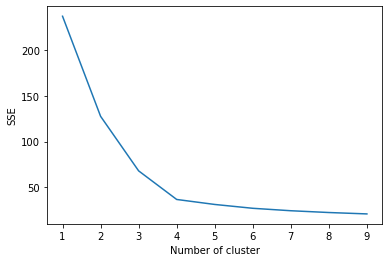

In [58]:
#print(X)
data = pd.DataFrame(npClusterData)

sse = {}

kmClusters = list()
for k in range(1, 10):
    km = cluster.KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = km.labels_
    kmClusters.append(km.labels_)
    #print(data["clusters"])
    sse[k] = km.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [63]:
ctr(kmClusters[3])
ipoDataDummied['Clusters'] = aggClusterModel.labels_

In [62]:
aggClusterModel = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=4).fit(pd.DataFrame(npClusterData))
aggClusterModel.labels_

array([2, 2, 1, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 3, 2, 1, 1, 2, 1, 3, 1,
       0, 0, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 0, 0, 3, 3, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2, 1, 1, 2, 1, 3, 3, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 0, 2, 3, 1, 3, 0, 2, 3, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 2, 3, 1, 0,
       3, 0, 3, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 3, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 3, 3, 3, 1, 1,
       1, 0, 3, 1, 3, 1, 2, 3, 3, 3, 2, 3, 2, 3, 0, 1, 1, 0, 3, 1, 1, 3,
       2, 1, 0, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 2, 1, 2, 3,
       2, 0, 1, 1, 2, 1, 1, 1, 0, 3, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0,
       1, 1, 2, 1, 1, 1, 0, 3, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 0, 0,
       0, 3, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 0, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,